> This is a self-correcting activity generated by [nbgrader](https://nbgrader.readthedocs.io). Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Run subsequent cells to check your code.

---

# Generate handwritten digits with a VAE (PyTorch)

The goal here is to train a VAE to generate handwritten digits.

![VAE digits](images/vae_digits.png)

## Environment setup

In [1]:
import os
import math

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'

In [11]:
# Import ML packages (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

PyTorch version: 1.5.1+cu101
cuda


## Data loading

In [15]:
# Load MNIST dataset
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transforms.ToTensor(), download=True
)
testset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transforms.ToTensor(), download=True
)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


### Question

Create batch data loaders `trainloader` and `testloader` resp. for training and test datasets.

In [8]:
batch_size = 128

trainloader = DataLoader(trainset, batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size, shuffle=True)

## Model definition

### Question

Complete the following class to create a variational autoencoder.

In [28]:
# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)
        self.fc4 = nn.Linear(latent_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        """Encode input into its latent representation
        Returns mean and standard deviation"""
        
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def sample(self, mu, log_var):
        """Sample a random codings vector from a gaussian distribution
        Takes mean and log_var (gamma) as parameters"""
        
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decode codings"""
        
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        """Encode inputs to obtain mean and standard deviation
           Sample codings from gaussian distribution using mean and std
           Returns decoded codings, mean and standard deviation"""
        
        mean, std = self.encode(x)
        rnd_point = self.sample(mean, std)
        decoded = self.decode(rnd_point)
        
        return decoded, mean, std

## Model training

### Question

Complete the following training loop to:
- instantiate the variational autoencoder on target device.
- instanciate the Adam optimizer.
- implement forward pass and gradient descent.

In [32]:
input_dim = 784
hidden_dim = 400
latent_dim = 20
num_epochs = 15
learning_rate = 1e-3
prints_per_epoch = 1  # Increase to see more feedback during training

# Instanciate VAE and optimizer
vae_model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = Adam(vae_model.parameters(), lr=learning_rate)


# Train model
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(trainloader):
             
        # Forward pass
        x = x.to(device).view(-1, input_dim)
        x_reconst, mu, log_var = vae_model.forward(x)

        # Compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction="sum")
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconst_loss + kl_div

        # Backprop and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print losses at regular intervals
        step_count = len(trainloader)
        print_threshold = math.ceil(step_count / prints_per_epoch)
        if (i + 1) % print_threshold == 0 or (i + 1) == step_count:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}]"
                f", step [{i + 1}/{step_count}]"
                f", reconst loss: {reconst_loss.item():.4f}"
                f", KL div: {kl_div.item():.4f}"
            )

Epoch [1/15], step [469/469], reconst loss: 10170.4199, KL div: 2017.4177
Epoch [2/15], step [469/469], reconst loss: 9178.0547, KL div: 2274.9014
Epoch [3/15], step [469/469], reconst loss: 8896.7725, KL div: 2315.8088
Epoch [4/15], step [469/469], reconst loss: 8106.9854, KL div: 2427.3921
Epoch [5/15], step [469/469], reconst loss: 8361.9902, KL div: 2432.4824
Epoch [6/15], step [469/469], reconst loss: 7968.5039, KL div: 2335.8259
Epoch [7/15], step [469/469], reconst loss: 7823.9053, KL div: 2396.3784
Epoch [8/15], step [469/469], reconst loss: 8108.3267, KL div: 2365.4861
Epoch [9/15], step [469/469], reconst loss: 8245.0674, KL div: 2490.6021
Epoch [10/15], step [469/469], reconst loss: 7937.5732, KL div: 2494.6843
Epoch [11/15], step [469/469], reconst loss: 7657.4106, KL div: 2401.2305
Epoch [12/15], step [469/469], reconst loss: 7561.5415, KL div: 2365.7168
Epoch [13/15], step [469/469], reconst loss: 7509.5518, KL div: 2485.8301
Epoch [14/15], step [469/469], reconst loss: 7

## Reconstructions visualization¶

In [36]:
def plot_image(image):
    plt.imshow(image.cpu().numpy().squeeze(), cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images, n_images=8):
    """Show original and reconstructed images side-by-side"""
    
    inputs = images.reshape(-1, 28*28).to(device)
    reconstructions, _, _ = model(inputs)
    
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index].view(1, 28, 28))

### Question

Show reconstructions for one batch of test data.

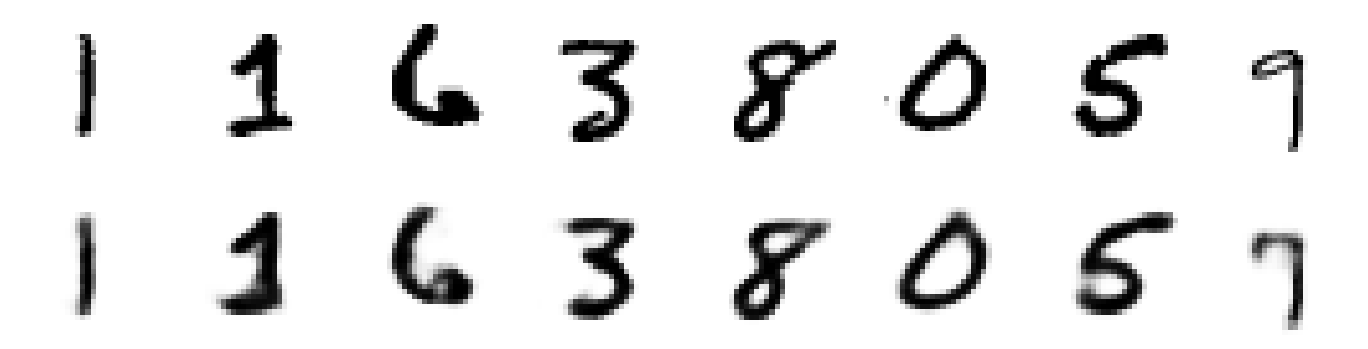

In [37]:
dataiter = iter(testloader)
images, _ = dataiter.next()

with torch.no_grad():
    show_reconstructions(vae_model, images)

## Generating new images¶

In [38]:
def plot_multiple_images(images, n_cols=None):
    """Show a series of images"""

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 1.5, 3))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image.numpy().squeeze(), cmap="binary")
        plt.axis("off")

### Question

Use the VAE to show several generated digits.

In [ ]:
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    # YOUR CODE HERE